# **Twitter (MFTC) pre-processing**
### **PERFECT: Prompt-free and Efficient Few-shot Learning with Language Models**


**PERFECT** is an approach to few-shot learning that doesn't require manual prompts or task-specific instructions. Instead, it uses the power of large pre-trained language models such as GPT-3 to learn new tasks from just a few examples. So PERFECT works by fine-tuning a **pre-trained language model** on a **small amount of labeled data** from a new task. The key innovation is to use a meta-learning algorithm that optimizes the fine-tuning process across multiple tasks, allowing the model to quickly adapt to new tasks with minimal training data.



The algorithm works by first **encoding a support set of examples into a representation that can be fed into the language model**. This representation is then used to generate a set of **synthetic examples** by conditioning the language model on a few-shot learning task description. The synthetic examples are used along with the support set to train a classifier.
During testing, the algorithm generates a set of synthetic examples for the test query, and these synthetic examples are used to make predictions. This approach has several advantages over traditional few-shot learning approaches. First, it is prompt-free, meaning that it does not require explicit instructions or prompts to be provided to the model. Second, it is highly efficient, as it leverages the pre-trained language model's ability to quickly generate synthetic examples.

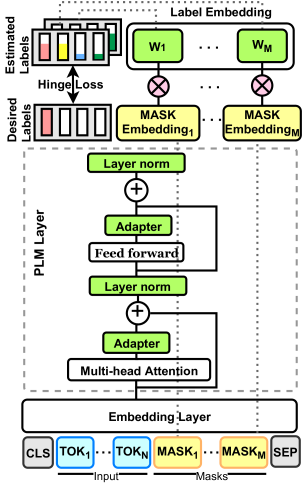

## **Reproduction result PERFECT with MFTC dataset**

In [1]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

# Load dataset (Reddit)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset (path is relative from .ipynb location)
data = pd.read_csv('MFTC.csv', engine='python')

# Show the first couple of rows...
print(data[:4])
print(len(data))

             tweet_id                                               text  \
0  521033092132503552  all lives matter peace and love prevail god bless   
1  537681598989475841  wholeheartedly support these protests acts of ...   
2  624644420705648640  this sandra bland situation man no disrespect ...   
3  752979765984890884  commitment to peace healing and loving neighbo...   

   fairness  non-moral  purity  degradation  loyalty  care  cheating  \
0       0.0        0.0     1.0          0.0      0.0   1.0       0.0   
1       0.0        0.0     0.0          0.0      1.0   0.0       0.0   
2       0.0        0.0     0.0          0.0      0.0   0.0       1.0   
3       0.0        0.0     1.0          0.0      0.0   1.0       0.0   

   betrayal  subversion  authority  harm  
0       0.0         0.0        0.0   0.0  
1       0.0         1.0        0.0   0.0  
2       0.0         0.0        0.0   0.0  
3       0.0         0.0        0.0   0.0  
7630


# Analyze data

non-moral      4064.0
harm            894.0
cheating        770.0
fairness        592.0
care            536.0
loyalty         453.0
betrayal        270.0
authority       259.0
subversion      229.0
degradation     124.0
purity           90.0
dtype: float64


Text(0, 0.5, 'Sums')

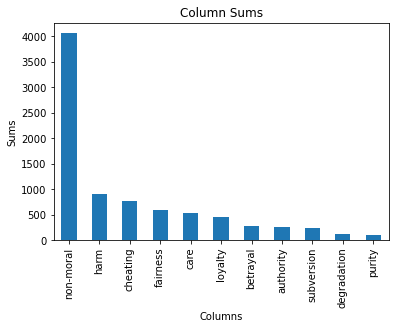

In [45]:
# sum over the columns
sums = data.iloc[:, 2:].sum(axis=0)

# sort the sums in descending order
sums = sums.sort_values(ascending=False)

# print the sums
print(sums)

# show bar plot
sums.plot.bar()
plt.title('Column Sums')
plt.xlabel('Columns')
plt.ylabel('Sums')


# Preprocess CSV datasets

The CSV contains a lot of information, such as annotator, confidence, subreddit, etc.. We are merely interested in pure classification. As such, the cell below will copy the CSV and condense it to just a `text-label` pair. The other information is not relevant in our research. We choose `N = 5` labels based on their occurence. In case of MFRC, we omit multi-label samples, and with MFTC, we simply choose randomly out of the labels

In [46]:
import random

def pick_label(row):
    labels = row[row == 1.0].index
    if len(labels) == 0:
        return None
    else:
        return random.choice(labels)
    
# Add row of single-label
data['label'] = data.apply(pick_label, axis=1)
data = data[['text', 'label']]

# Purge low-occurence labels
label_counts = data['label'].value_counts()

N_min = 430
mask = data['label'].isin(label_counts[label_counts >= N_min].index)
data_reduced = data[mask]

# Create a mapping from label (Purity, Equality, Non-Moral,Care, etc.) to label
annotations = data_reduced['label'].unique()
mapping = {value:idx for idx, value in enumerate(annotations)}
inverse_mapping = {idx:value for idx, value in enumerate(annotations)}

# Map string labels to integer label
data_reduced.loc[:, 'label'] = data_reduced['label'].map(mapping)
data_reduced = data_reduced[['label', 'text']]

/tmp/ipykernel_8920/1816329306.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reduced.loc[:, 'label'] = data_reduced['label'].map(mapping)


# Statistical analysis of class distribution

Amount of unique labels: 5
['cheating' 'care' 'non-moral' 'fairness' 'harm']


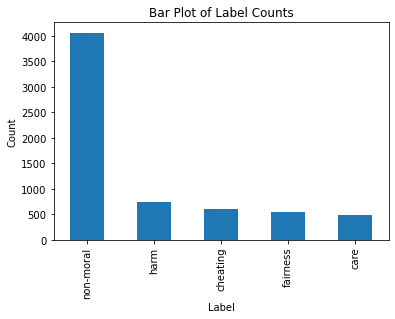

In [47]:
import matplotlib.pyplot as plt

print(f'Amount of unique labels: {len(annotations)}')
print(annotations)

bins = data_reduced['label'].value_counts()
bins.index = [inverse_mapping[idx] for idx in bins.index]
bins.plot(kind='bar')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Plot of Label Counts')
plt.show()

# Create train/test data from datasets

In [49]:
# Split dataset into train and test sets
train_data, test_data = train_test_split(data_reduced, test_size=0.2, random_state=42)

# Save train and test sets as separate CSV files
train_data.to_csv("train_mftc.csv", index=False, header=False)
test_data.to_csv("test_mftc.csv", index=False, header=False)

# Print information about train and test data
print(f'Training data contains {len(train_data)} samples. A few examples: \n')
print(train_data[:4])
print(3*'\n')
print(f'Test data contains {len(test_data)} samples. A few examples: \n')
print(test_data[:4])

Training data contains 5126 samples. A few examples: 

      label                                               text
916       4  it is a shame skin color and beliefs fuel hatr...
5318      2  hugot face with tears of joy face with tears o...
1612      3  a spirit of equality and faith as long as you ...
6384      2  local tv coverage of freddie gray press confer...




Test data contains 1282 samples. A few examples: 

      label                                               text
3014      2  it also takes away from the statement that all...
6533      2  our own offers some expert tips on enterprise ...
2912      4         the insidious violence of all lives matter
1634      1   love and sacrifice for humanity all lives matter
